## Nathan's Kaggle Dogs vs Cats Redux

This notebooks will:

0. Introduce one way to pull data from kaggle
1. Create directory structure for utilities, vgg, and data (training, validation, sample, and test)
2. Download and unzip necessary data from Kaggle
3. Set up VGG to analyze training images and build model
4. Finetune the model to categorize just dogs and cats
5. Submit results to Kaggle via Kaggle CLI

# Downloading kaggle data

While a client for downloading kaggle exists, [kaggle-cli](https://github.com/floydwch/kaggle-cli), I had trouble with it.  

Instead I logged into Kaggle in Chrome and [copied the curl request](https://coderwall.com/p/-fdgoq/chrome-developer-tools-adds-copy-as-curl), then pasted that into the command line followed by -o filename.zip to make sure the output was to a file and not to STDOUT.

After dowloading both train.zip and test.zip, I unzipped the contents into the /data/redux/ directory

## Double Check Directory Structure

For now, we should have a directory structure that looks like this:

```
utils/
    vgg16.py                        // from fast.ai, this is the algorithm for image classification
    utils.py                        // from fast.ai, this is a collection of functions
lesson1/
    nathan_dogs_cats_redux.ipynb    // this file
    data/
        redux/                      // kaggle data will be put into this dir and unzipped into train/ and test/
            train/
                cat.348.jpg
                dog.3778.jpg
                ...
            test/
                123.jpg
                857.jpg
                ...
```                

In [1]:
# sanity check to make sure we are in the right directory (/home/ubuntu/nbs/dogs_or_cats/)
%pwd

u'/home/ubuntu/nbs/dogs_or_cats'

In [2]:
# allow plots to show up in this notebook
%matplotlib inline

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
# create references to directories we will use often
import os, sys
current_dir = os.getcwd()
HOME_DIR_LESSON = current_dir 
HOME_DIR_DATA = current_dir+'/data/redux'

In [12]:
# download kaggle data and unzip if this hasn't been done before
if os.path.isfile(HOME_DIR_DATA+'/train.zip') == False:
    print("No Kaggle Training zip found, double check you have training data")
elif os.path.isfile(HOME_DIR_DATA+'/test.zip') == False:
    print("No Kaggle Testing zip found, double check you have test data")
else:
    print("Kaggle zips found, assuming they've been unzipped appropriately")

Kaggle zips found, assuming they've been unzipped appropriately


In [13]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [14]:
print HOME_DIR_LESSON

/home/ubuntu/nbs/dogs_or_cats


# Slice up Kaggle Data for training

Now we're going to slice up the Kaggle data into further pieces, e.g the training set will be broken up into 3 subsets: train, validate, and sample.  We will create new directories and move around Kaggle data appropriately.

##  1. Create proper directory structure

```
utils/
lesson1/
    data/
        redux/                       
            train/
            test/
                *unknown/
            *valid/
            *results/
            *sample/
                *train/
                *test/
                *valid/
                *results/
            
        
```         

In [15]:
# Create directories if they don't exist
%cd $HOME_DIR_DATA

if os.path.exists(HOME_DIR_DATA+'/valid') == False:
    %mkdir valid
if os.path.exists(HOME_DIR_DATA+'/results') == False:
    %mkdir results
if os.path.exists(HOME_DIR_DATA+'/sample/train') == False:
    %mkdir -p sample/train
if os.path.exists(HOME_DIR_DATA+'/sample/test') == False:
    %mkdir -p sample/test
if os.path.exists(HOME_DIR_DATA+'/sample/valid') == False:
    %mkdir -p sample/valid
if os.path.exists(HOME_DIR_DATA+'/sample/results') == False:
    %mkdir -p sample/results
if os.path.exists(HOME_DIR_DATA+'/test/unknown') == False:
    %mkdir -p test/unknown
if os.path.exists(HOME_DIR_DATA+'/sample/test/unknown') == False:
    %mkdir -p sample/test/unknown

/home/ubuntu/nbs/dogs_or_cats/data/redux


## 2. Break up Kaggle data

In [16]:
%cd $HOME_DIR_DATA/train

/home/ubuntu/nbs/dogs_or_cats/data/redux/train


In [17]:
# import glob module for finding pathnames (note: results in arbitrary order)
import glob 
import numpy as np

##### Get all training data and shuffle it before breaking it up

In [18]:
# get array of all files in training set
training_pics = glob.glob('*.jpg')
# permute them for randomization
shuf = np.random.permutation(training_pics)
train_set_size = len(shuf)
print train_set_size,': total training files'

25000 : total training files


### *Seperate* Data For Validation Set

##### Separate (i.e. move) 10% of original training data off for validation set.  This shouldn't be done more than once.

In [19]:
valid_set_size = int(train_set_size*0.1)
if len(os.listdir(HOME_DIR_DATA+'/valid/')) == 0:
    for i in range(valid_set_size):
        os.rename(shuf[i], HOME_DIR_DATA+'/valid/' + shuf[i])

### *Copy* Data For Test Set

##### Copy ~1% subset of remaining training data for sampling (i.e. training on very small dataset for speed considerations)

In [25]:
from shutil import copyfile

In [40]:
# get array of remaining files after splitting off validation set
training_pics_sub_val = glob.glob('*.jpg')
shuf = np.random.permutation(training_pics_sub_val)
sample_test_size = int(len(shuf)*0.01)
if len(os.listdir(HOME_DIR_DATA+'/sample/train/')) == 0:
    for i in range(sample_test_size):
        copyfile(shuf[i], HOME_DIR_DATA+'/sample/train/'+shuf[i])

##### Copy ~2% subset of seperated validation data for sampling

In [41]:
%cd $HOME_DIR_DATA/valid

/home/ubuntu/nbs/lesson1/data/redux/valid


In [45]:
if len(os.listdir(HOME_DIR_DATA+'/sample/valid/')) == 0:
    print('/sample/valid is empty')
    validation_set = glob.glob("*.jpg")
    shuf = np.random.permutation(validation_set)
    sample_valid_size = int(len(shuf)*0.02)
    for i in range(sample_valid_size):
        copyfile(shuf[i], HOME_DIR_DATA+'/sample/valid/'+shuf[i])

/sample/valid is empty


##### Copy ~1% subset of testing data for sample test set

In [29]:
%cd $HOME_DIR_DATA/test/unknown

/home/ubuntu/nbs/lesson1/data/redux/test/unknown


In [34]:
if len(os.listdir(HOME_DIR_DATA+'/sample/test/unknown')) == 0:
    print('/sample/test/uknown is empty')
    test_set = glob.glob("*.jpg")
    shuf = np.random.permutation(test_set)
    sample_test_size = int(len(shuf)*0.01)
    print len(shuf), sample_test_size
    for i in range(sample_test_size):
        copyfile(shuf[i], HOME_DIR_DATA+'/sample/test/unknown/'+shuf[i])

 /sample/test/uknown is empty
12500 125


### *Break up* Sets into folders

In [46]:
%cd $HOME_DIR_DATA/sample/train

/home/ubuntu/nbs/lesson1/data/redux/sample/train


In [48]:
os.path.isdir(HOME_DIR_DATA+'/sample/train/dogs')

False

In [49]:
# Divide sample train cat/dog images into seperate directories

%cd $HOME_DIR_DATA/sample/train
if os.path.isdir(HOME_DIR_DATA+'/sample/train/dogs') == False:
    %mkdir dogs
    %mv dog.*.jpg dogs/
if os.path.isdir(HOME_DIR_DATA+'/sample/train/cats') == False:
    %mkdir cats
    %mv cat.*.jpg cats/

/home/ubuntu/nbs/lesson1/data/redux/sample/train


In [50]:
# Divide sample valid cat/dog images into seperate directories

%cd $HOME_DIR_DATA/sample/valid
if os.path.isdir(HOME_DIR_DATA+'/sample/valid/dogs') == False:
    %mkdir dogs
    %mv dog.*.jpg dogs/
if os.path.isdir(HOME_DIR_DATA+'/sample/valid/cats') == False:
    %mkdir cats
    %mv cat.*.jpg cats/

/home/ubuntu/nbs/lesson1/data/redux/sample/valid


In [20]:
# Divide training set cat/dog images into seperate directories

%cd $HOME_DIR_DATA/train
if os.path.isdir(HOME_DIR_DATA+'/train/dogs') == False:
    %mkdir dogs
    %mv dog.*.jpg dogs/
if os.path.isdir(HOME_DIR_DATA+'/train/cats') == False:
    %mkdir cats
    %mv cat.*.jpg cats/

/home/ubuntu/nbs/dogs_or_cats/data/redux/train


In [21]:
# Divide validation set cat/dog images into seperate directories

%cd $HOME_DIR_DATA/valid
if os.path.isdir(HOME_DIR_DATA+'/valid/dogs') == False:
    %mkdir dogs
    %mv dog.*.jpg dogs/
if os.path.isdir(HOME_DIR_DATA+'/valid/cats') == False:
    %mkdir cats
    %mv cat.*.jpg cats/

/home/ubuntu/nbs/dogs_or_cats/data/redux/valid


### Create single 'unknown' class for test set

In [22]:
%cd $HOME_DIR_DATA/test
%mv *.jpg unknown/

/home/ubuntu/nbs/dogs_or_cats/data/redux/test


# Train First Generation Model

In [23]:
# import modules
%cd $HOME_DIR_LESSON
from utils import utils
from utils.vgg16 import Vgg16

/home/ubuntu/nbs/dogs_or_cats


Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


#### We use vgg16, an existing image classifier which classifies images into one of 1000 different categories found on imagenet.

In [24]:
%cd $HOME_DIR_DATA

# set paths for training set (can take away sample/ once evertyhing's working)
path = HOME_DIR_DATA + '/' #'/sample/' for sample dataset
test_path = path + 'test/'
results_path = path + 'results/'
train_path = path + 'train/'
valid_path = path + 'valid/'

/home/ubuntu/nbs/dogs_or_cats/data/redux


In [25]:
# set Vgg16 helper class from vgg16 library -- this is a pretrained model with *.h5 file for weights that will be used
vgg = Vgg16()

24576/35363 [===================>..........] - ETA: 0s

In [26]:
# set constants: 
# batch size usu. recommended to be no larger than 64, can adjust
# to be smaller if running out of memory
batch_size = 64
# Increasing no_of_epochs should improve accuracy
no_of_epochs = 10

In [27]:
# label training set and validation set:
# use vgg to collect data by the batch (associate images with label according to directory structure)
# a batch is a collection of images and labels from, 
# and batches is an iterator that can help cycle through all of them in stages
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Let's see what we have so far

In [28]:
from matplotlib import pyplot as plt

#### Here are the first few images/labels of our pre-labeled data from the *first* batch

In [13]:
imgs,labels = next(batches)

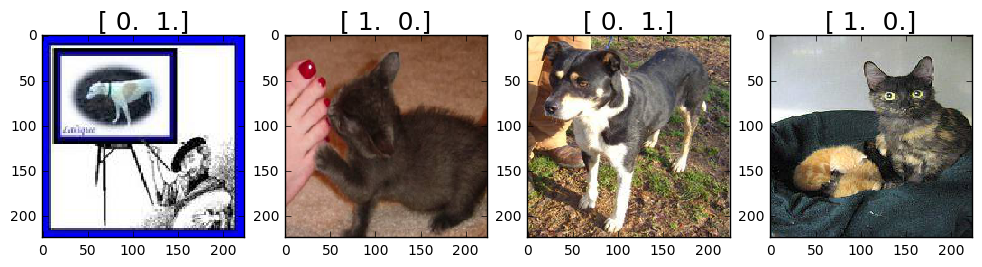

In [14]:
utils.plots(imgs[:8],titles=labels[:8])

#### ...and here are the first few images from the *second* batch

In [15]:
imgs,labels = next(batches)

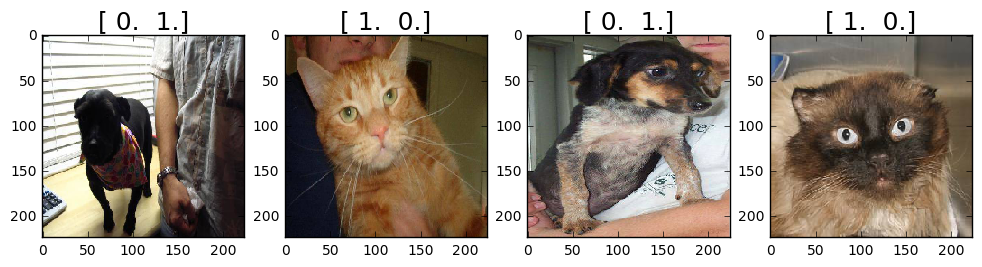

In [16]:
utils.plots(imgs[:8],titles=labels[:8])

#### Let's see how vgg16 would classify these images (so far it's just put them in buckets for analysis， which we haven't done yet).  vgg16 was origionally inteneded to classify images in one of 1000 categories from imagenet.  

Here's how they would have been classified, along with the probabilities for the assigned class

In [58]:
vgg.predict(imgs[:8], True)

(array([ 0.4016,  0.3771,  0.4494,  0.3542,  0.1606,  0.4045,  0.2939,  0.2297,  0.3585,  0.4419], dtype=float32),
 array([229, 257, 248, 728, 227, 797, 434, 235, 285, 180]),
 [u'Old_English_sheepdog',
  u'Great_Pyrenees',
  u'Eskimo_dog',
  u'plastic_bag',
  u'kelpie',
  u'sleeping_bag',
  u'bath_towel',
  u'German_shepherd',
  u'Egyptian_cat',
  u'American_Staffordshire_terrier'])

## Training the model

Vgg16 was made to categorize images into one of 1,000 specific categories.  We want to "finetune" this model to just care about "cats" or "dogs".

When finetuning, we will provide vgg with both a training set to learn from and a validation set to test against.  The resulting model will have the parameters tuned according to this data.

In [29]:
# finetune() modifies vgg16 model s.t. it will be trained based only
# on the data in the batches provided, i.e. either "cat" or "dog"
vgg.finetune(batches)

In [30]:
# fit() fits the parameters of the model using the training data, 
# reports the accuracy compared to the validation set after each epoch,
# One epoch is one full pass through the training data.
latest_weights = None
for epoch in range(no_of_epochs):
        print "Running epoch #", epoch
        vgg.fit(batches, val_batches,nb_epoch=1)
        if(epoch == (no_of_epochs-1)):
            latest_weights = 'weights_epoch_%d.h5' % epoch
            vgg.model.save_weights(results_path+latest_weights)
print 'Fit complete over %d epochs' % no_of_epochs

Running epoch # 0
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.1198 - acc: 0.9684 - val_loss: 0.0415 - val_acc: 0.9864
Running epoch # 1
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.1030 - acc: 0.9766 - val_loss: 0.0413 - val_acc: 0.9888
Running epoch # 2
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.0962 - acc: 0.9790 - val_loss: 0.0476 - val_acc: 0.9832
Running epoch # 3
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.0933 - acc: 0.9787 - val_loss: 0.0640 - val_acc: 0.9824
Running epoch # 4
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.1070 - acc: 0.9786 - val_loss: 0.0630 - val_acc: 0.9844
Running epoch # 5
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.1098 - acc: 0.9789 - val_loss: 0.0639 - val_acc: 0.9824
Running epoch # 6
Epoch 1/1
22500/22500 [==============================] - 606s - loss: 0.1088 - acc: 0.9805 - val_loss: 0.0

# Make predictions with model

In [31]:
batches, preds = vgg.test(test_path, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [32]:
# do a quick check on the resulting data
filenames = batches.filenames
for i in range(5):
    print preds[i], filenames[i]

[  1.0000e+00   3.6855e-17] unknown/9292.jpg
[ 0.8476  0.1524] unknown/12026.jpg
[  1.0000e+00   7.4676e-10] unknown/9688.jpg
[  1.0000e+00   1.1765e-23] unknown/4392.jpg
[  6.3084e-14   1.0000e+00] unknown/779.jpg


In [34]:
# Compare the value to the pictures themselves
from PIL import Image

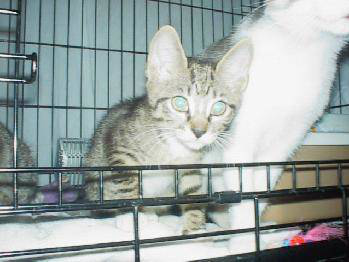

In [35]:
Image.open(test_path+filenames[0])

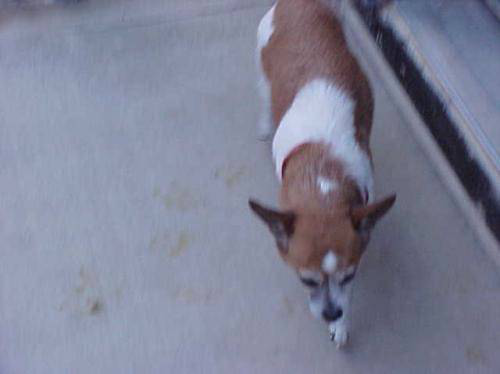

In [36]:
Image.open(test_path+filenames[1])

In [37]:
# Save prediction results to disk
utils.save_array(results_path + 'predictions_categories_p2_10_epochs_10p_validation.dat', preds)
utils.save_array(results_path + 'predictions_filenames_p2_10_epochs_10p_validation.dat', filenames)

# Validate our Model

#### Now that our model is trained, we should compare its predictions to the validation set to see how close our predictions are compared the correct labels known a priori.

In [38]:
# assign the latest weights from the model to vgg
vgg.model.load_weights(results_path+latest_weights)

In [39]:
# prepare validation set by batching and pre-labelling
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2500 images belonging to 2 classes.


In [40]:
filenames = val_batches.filenames
expected_labels = val_batches.classes # {0，1}

# round predictions to 0/1 to generate labels
model_predictions = probs[:,0]
model_labels = np.round(1-model_predictions)

In [41]:
print model_predictions

[  1.0000e+00   1.0000e+00   1.0000e+00 ...,   5.0403e-13   9.4445e-16   1.5270e-10]


In [42]:
print model_labels

[ 0.  0.  0. ...,  1.  1.  1.]


In [43]:
from keras.preprocessing import image

# define helper function to plot images by index in the validation set
# note: plots is a helper function from utils.py
def plots_idx(idx, titles=None):
    utils.plots([image.load_img(valid_path + filenames[i]) for i in idx], titles = titles)
    
# number of images to view for each validation task
n_view = 6

There are a total of 2467 correct labels


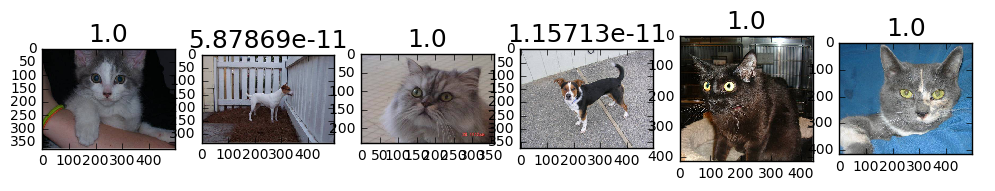

In [44]:
# here are some examples of correctly labelled images
correct = np.where(model_labels==expected_labels)[0]
print "There are a total of %d correct labels" % len(correct)
index = np.random.permutation(correct)[:n_view]
plots_idx(index, model_predictions[index])

There are a total of 33 incorrect lables


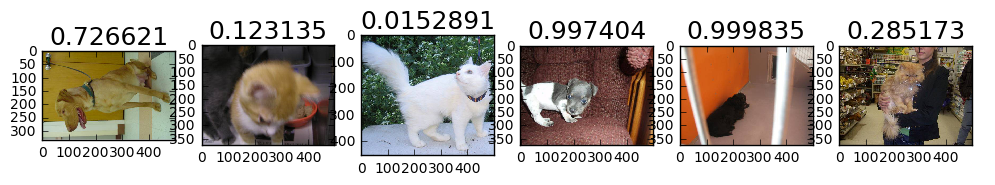

In [45]:
# here are some examples of incorrectly labeled images
incorrect = np.where(model_labels!=expected_labels)[0]
print "There are a total of %d incorrect lables" % len(incorrect)
index = np.random.permutation(incorrect)[:n_view]
plots_idx(index, model_predictions[index])

# Prepare for submittion to Kaggle